In [20]:
import os
import numpy as np
import numpy.testing as npt
from dataclasses import dataclass
from rich.progress import Progress
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegFileWriter

import jax

import jax.numpy as jnp

%env MICROMAGE_DOUBLE=1
import micromage as mg
print(f"{mg.dtype=}")

from dataclasses import replace

env: MICROMAGE_DOUBLE=1
mg.dtype=<class 'jax.numpy.float64'>


In [21]:
system = mg.System(
    Lx=18, Ly=18, Di=3.5*0, K=7.7*0, H=0, A=1*0,
    eta=0.2, jx=0, beta=0.,
    imp_x = np.array([8],dtype=mg.dtype),
    imp_y = np.array([7],dtype=mg.dtype),
    imp_K = np.array([1],dtype=mg.dtype),    
)
print(system)

comp = mg.Computer2(system)
xy = comp.coordinates(300, 300)

a = mg.AnalyticA(system=system, xy=xy)

rad0 = 4.
wdt0 = 0.5
p0 = np.array([system.Lx/2,system.Ly/2,rad0,wdt0,0,0,0.0])
print(f"Initial parameters {p0}")
n0 = a(p0)
print("Energy micromagnetic", comp.energy(n0))
print("Energy analytic", a.energy(p0))

System(A=0, J=1, Db=0, Di=0.0, H=0, K=0.0, Lx=18, Ly=18, Ms=1, gamma=1, eta=0.2, beta=0.0, jx=0, jy=0.0, imp_x=array([8.]), imp_y=array([7.]), imp_K=array([1.]))
Initial parameters [9.  9.  4.  0.5 0.  0.  0. ]
Energy micromagnetic 0.9965558000172562
Energy analytic 0.9965570210279924


/home/igor/micromage/micromage/analytic.py:100: RuntimeWarning: divide by zero encountered in divide
  return np.sinh(rad/wdt)/np.sinh(rho/wdt)


In [22]:
e0 = a.energy(p0)
grad = a.d_energy(p0)
print(f"{grad = }")
dp = np.random.randn(*p0.shape).astype(mg.dtype)
de = np.sum(grad*dp)

epses = np.logspace(-4,-1,8)[::-1]
energies = np.empty(epses.shape, dtype=mg.dtype)
a_energies = np.empty(epses.shape, dtype=mg.dtype)
for i, eps in enumerate(epses):
    p1 = p0+eps*dp
    n1 = a(p1)
    energies[i] = e = comp.energy(n1)
    a_energies[i] = a_e = a.energy(p1)
    print(f"eps {eps:.5f}: {e:.5f} {e-e0} {a_e-e0} {eps*de}")


grad = array([-0.00614998, -0.01229996,  0.01374819, -0.04848571,  0.        ,
        0.        ,  0.        ])
eps 0.10000: 0.99273 -0.003829134284508262 -0.0038281126350006023 -0.0033065555678276058
eps 0.03728: 0.99524 -0.0013168808929036047 -0.0013157065716092875 -0.0012325495770506578
eps 0.01389: 0.99608 -0.000472772850025005 -0.0004715637178248633 -0.0004594444063390869
eps 0.00518: 0.99638 -0.0001741928919993807 -0.00017297543861016784 -0.0001712622083903407
eps 0.00193: 0.99649 -6.529897043838773e-05 -6.407915919726115e-05 -6.383959325231022e-05
eps 0.00072: 0.99653 -2.5050754089650518e-05 -2.3830172599770272e-05 -2.379680669147717e-05
eps 0.00027: 0.99655 -1.0095976182289412e-05 -8.875122952223258e-06 -8.87048271866988e-06
eps 0.00010: 0.99655 -4.52815290852282e-06 -3.307200536095678e-06 -3.306555567827606e-06


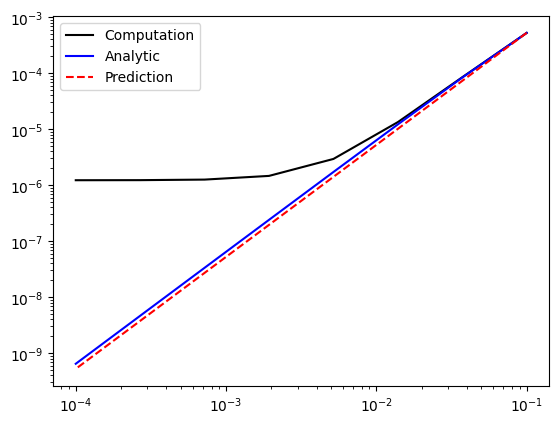

In [23]:
fig, ax = plt.subplots()
error = np.abs(energies-e0-epses*de)
a_error = np.abs(a_energies-e0-epses*de)
ax.loglog(epses, error, '-k', label='Computation')
ax.loglog(epses, a_error, '-b', label='Analytic')
ax.loglog(epses, (epses/epses[0])**2*error[0], '--r', label='Prediction')
ax.legend()
plt.show()

In [24]:
def ansatz(params, xy):
    x0, y0, radius, width, chirality, skew, torsion = params
    # DOI: 10.1038/s42005-018-0029-0
    x, y = xy[0]-x0, xy[1]-y0 # Cartesian coordinate in place centered at the skyrmion.
    rho2 = x**2+y**2 + 1e-12 #
    rho = jnp.sqrt(rho2) # Polar radius.
    x, y = x/rho, y/rho # Direction outside the skyrmmion.
    n_theta = 2*jnp.arctan2(jnp.sinh(radius/width), jnp.sinh(rho/width)) # Ansatz skyrmion profile.
    nz, nxy = jnp.cos(n_theta), jnp.sin(n_theta) # Out of plane and in plane projections of magnetization.
        
    # n_phi = nu*phi+gamma,  
    # where nu is vorticity (nu = 1 for a skyrmion and nu = −1 for an antiskyrmion), 
    # and gamma is a constant classifying type of skyrmions=chirality 
    # (gamma=0 or pi for Néel skyrmions and gamma = +-pi/2 for Bloch skyrmions).
    dr = radius-rho
    angle = chirality + dr*skew + dr*jnp.arctan(dr)*torsion
    c, s = jnp.cos(angle), jnp.sin(angle)
    nx = nxy*(c*x+s*y) # x-projection
    ny = nxy*(-s*x+c*y) # y-projection of magnetization.
    n1 = jnp.stack([nx,ny,nz],axis=0) # 1st layer.
    return n1[:,:,:,None] # Single layer state.



In [83]:
def simpson(dx, y):
    assert y.shape[0]%2==1
    return (1/3*jnp.sum(y[2:-1:2])+2/3*jnp.sum(y[1::2])+(y[0]+y[-1])/6)*2*dx

# TEST
# x = np.linspace(0,1,101)
# y = x**4
# print(simpson(x[1]-x[0],y))


class Analytic:
    def __init__(self, system: mg.System=None, xy=None):
        self.system = system
        self.xy = xy
        self.d_energy = jax.grad(self.energy, argnums=0)
    
    def ansatz(self, pars, xy=None):
        if xy is None: xy = self.xy
        x0, y0, rad, wdt, chi, _, _ = pars
        x, y = xy[0]-x0, xy[1]-y0
        rho = jnp.sqrt(x**2+y**2)
        phi = jnp.arctan2(y, x)
        psi = phi - chi
        theta = self.theta(rho, rad,wdt)
        nx = jnp.cos(psi)*jnp.sin(theta)
        ny = jnp.sin(psi)*jnp.sin(theta)
        nz = jnp.cos(theta)
        return jnp.stack([nx,ny,nz],axis=0)[...,None]
            
    def theta(self, rho, rad, wdt):
        q = self.q(rho, rad, wdt)
        theta = 2*jnp.arctan(q)
        return theta
    
    def dtheta_drho(self, rho, rad, wdt):
        q, dq = self.q(rho, rad, wdt), self.dq_drho(rho, rad, wdt) 
#         print(f"{q=}")
#         print(f"{dq=}")        
        return 2*jnp.arctan(q), 2/(1+q**2)*dq
        
    def __call__(self, p):
        return self.ansatz(p)
        
    def q(self, rho, rad, wdt):
        return jnp.sinh(rad/wdt)/jnp.sinh(rho/wdt)
    
    def dq_drho(self, rho, rad, wdt):
        return -self.q(rho, rad, wdt)/wdt/jnp.tanh(rho/wdt)
    
    def dq_drad(self, rho, rad, wdt):
        return self.q(rho, rad, wdt)/wdt/jnp.tanh(rad/wdt)
    
    def dq_dwdt(self, rho, rad, wdt):
        return self.q(rho, rad, wdt)/wdt**2*(rho/jnp.tanh(rho/wdt)-rad/jnp.tanh(rad/wdt))
    
    
    def energy(self, pars):
        _,_,rad,wdt,chi,_,_=pars
        rho =  jnp.linspace(1e-8,10,1001)
        theta, dtheta = self.dtheta_drho(rho, rad,wdt)
        si = self.ansatz(pars, [self.system.imp_x, self.system.imp_y])
#         print(f"{theta=}")
#         print(f"{dtheta=}")        
        return ( 2*np.pi*self.system.A*self.I1(rho, theta, dtheta)
                +2*np.pi*(self.system.Db*jnp.sin(-chi)+self.system.Di*jnp.cos(chi))*self.I2(rho, theta, dtheta)
                +2*np.pi*self.system.K*self.I3(rho, theta)
                +2*np.pi*self.system.H*self.I4(rho, theta)
                +jnp.sum(self.system.imp_K[:,None]*si[2]**2)
                )


    def I1(self, rho, theta, dtheta):
        """
        int_0^infty [(d theta/d r)^2+sin^2(theta)/r^2] r dr
        """
        y = rho*dtheta**2+jnp.sin(theta)**2/rho
        return simpson(rho[1]-rho[0], y) 
    
    def I2(self, rho, theta, dtheta):
        """
        int_0^infty [d theta/d r+sin(2 theta)/(2 r)] r dr
        """
        y = rho*dtheta+jnp.sin(2*theta)/2
        return simpson(rho[1]-rho[0], y) 
    
    def I3(self, rho, theta):
        """
        int_0^infty sin^2(theta) r dr
        """
        y = jnp.sin(theta)**2*rho
        return simpson(rho[1]-rho[0], y) 

    
    def I4(self, rho, theta):
        """
        int_0^infty (1-cos(theta)) r dr
        """
        y = (1-jnp.cos(theta))*rho
        return simpson(rho[1]-rho[0], y) 



In [119]:
class AnalyticI:
    def __init__(self, system: mg.System=None, xy=None, nint=1+2**10, krad=10):
        self.system = system
        self.xy = xy
        self.nint = nint
        assert self.nint>0 and self.nint%2==1
        self.krad = krad
    
    def ansatz(self, pars, xy=None):
        if xy is None: xy = self.xy
        x0, y0, rad, wdt, chi, _, _ = pars
        x, y = xy[0]-x0, xy[1]-y0
        rho = np.sqrt(x**2+y**2)
        phi = np.arctan2(y, x)
        psi = phi - chi
        theta = self.theta(rho, rad,wdt)
        nx = np.cos(psi)*np.sin(theta)
        ny = np.sin(psi)*np.sin(theta)
        nz = np.cos(theta)
        return np.stack([nx,ny,nz],axis=0)[...,None]


    def v_d_ansatz(self, pars, xy=None):
        x0, y0, rad, wdt, chi, _, _ = np.array(pars, dtype=mg.dtype)

        if xy is None: xy=self.xy
        x, y = xy[0]-x0, xy[1]-y0

        rho = np.sqrt(x**2+y**2)
        phi = np.arctan2(y, x)
        psi = phi - chi
        theta = self.theta(rho, rad, wdt)
        nx = np.cos(psi)*np.sin(theta)
        ny = np.sin(psi)*np.sin(theta)
        nz = np.cos(theta)

        nx_theta = np.cos(psi)*np.cos(theta)
        ny_theta = np.sin(psi)*np.cos(theta)
        nz_theta = -np.sin(theta)
        nx_psi = -np.sin(psi)*np.sin(theta)
        ny_psi = np.cos(psi)*np.sin(theta)

        rho_x0, rho_y0 = -x/rho, -y/rho
        phi_x0 = y/(x**2+y**2) 
        phi_y0 = -x/(x**2+y**2) 

        _theta, theta_rad, theta_wdt, theta_rho, _dtheta_rad, _dtheta_wdt = self.dtheta_dall(rho,rad,wdt)

        nx_x0 = nx_theta*theta_rho*rho_x0 + nx_psi*phi_x0
        ny_x0 = ny_theta*theta_rho*rho_x0 + ny_psi*phi_x0
        nz_x0 = nz_theta*theta_rho*rho_x0

        nx_y0 = nx_theta*theta_rho*rho_y0 + nx_psi*phi_y0
        ny_y0 = ny_theta*theta_rho*rho_y0 + ny_psi*phi_y0
        nz_y0 = nz_theta*theta_rho*rho_y0

        nx_rad = nx_theta*theta_rad 
        ny_rad = ny_theta*theta_rad 
        nz_rad = nz_theta*theta_rad

        nx_wdt = nx_theta*theta_wdt 
        ny_wdt = ny_theta*theta_wdt 
        nz_wdt = nz_theta*theta_wdt

        nx_chi = -nx_psi
        ny_chi = -ny_psi

        z = np.zeros_like(nx_x0)

        return np.array([nx,ny,nz])[...,None], np.array([
                [nx_x0, nx_y0, nx_rad, nx_wdt, nx_chi, z, z],
                [ny_x0, ny_y0, ny_rad, ny_wdt, ny_chi, z, z],
                [nz_x0, nz_y0, nz_rad, nz_wdt, z,      z, z],
            ], dtype=z.dtype)[...,None]
    
    def theta(self, rho, rad, wdt):
        q = self.q(rho, rad, wdt)
        theta = 2*np.arctan(q)
        return theta
    
    def dtheta_drho(self, rho, rad, wdt):
        q, dq = self.q(rho, rad, wdt), self.dq_drho(rho, rad, wdt) 
        return 2*np.arctan(q), 2/(1+q**2)*dq
    
    def dtheta_dall(self, rho, rad, wdt):
        q = self.q(rho, rad, wdt)
        dq_rho = self.dq_drho(rho, rad, wdt)
        dq_rad = self.dq_drad(rho, rad, wdt)
        dq_wdt = self.dq_dwdt(rho, rad, wdt)
        ddq_rho_rad = self.dq_drho_drad(rho, rad, wdt)
        ddq_rho_wdt = self.dq_drho_dwdt(rho, rad, wdt)
        theta = 2*np.arctan(q)
        theta_rad = 2/(1+q**2)*dq_rad
        theta_wdt = 2/(1+q**2)*dq_wdt
        dtheta = 2/(1+q**2)*dq_rho
        dtheta_rad = -4*q/(1+q**2)**2*dq_rad*dq_rho+2/(1+q**2)*ddq_rho_rad
        dtheta_wdt = -4*q/(1+q**2)**2*dq_wdt*dq_rho+2/(1+q**2)*ddq_rho_wdt
        return theta, theta_rad, theta_wdt, dtheta, dtheta_rad, dtheta_wdt
        
    
    def __call__(self, p):
        return self.ansatz(p)
        
    def q(self, rho, rad, wdt):
        return np.sinh(rad/wdt)/np.sinh(rho/wdt)
    
    def dq_drho(self, rho, rad, wdt):
        return -self.q(rho, rad, wdt)/wdt/np.tanh(rho/wdt)
    
    def dq_drho_drad(self, rho, rad, wdt):
        return -self.dq_drad(rho, rad, wdt)/wdt/np.tanh(rho/wdt)
    
    def dq_drho_dwdt(self, rho, rad, wdt):
        r = rho/wdt
        wt = wdt*np.tanh(r)
        dwt = np.tanh(r)-r/np.cosh(r)**2
        return (
            -self.dq_dwdt(rho, rad, wdt)/wt
            +self.q(rho, rad, wdt)/wt**2*dwt
        )
    
    def dq_drad(self, rho, rad, wdt):
        return self.q(rho, rad, wdt)/wdt/np.tanh(rad/wdt)
    
    def dq_dwdt(self, rho, rad, wdt):
        return self.q(rho, rad, wdt)/wdt**2*(rho/np.tanh(rho/wdt)-rad/np.tanh(rad/wdt))
    
    
    def energy(self, pars):
        _,_,rad,wdt,chi,_,_=pars
        rho =  np.linspace(1e-8,self.krad,self.nint)
        theta, dtheta = self.dtheta_drho(rho*rad, rad,wdt)
        dtheta *= rad
        si = self.ansatz(pars, [self.system.imp_x, self.system.imp_y])
        D = self.system.Db*np.sin(-chi)+self.system.Di*np.cos(chi)
        return ( 2*np.pi*self.system.A*self.I1(rad, rho, theta, dtheta)
                +2*np.pi*D*self.I2(rad, rho, theta, dtheta)
                +2*np.pi*self.system.K*self.I3(rad, rho, theta)
                +2*np.pi*self.system.H*self.I4(rad, rho, theta)
                +np.sum(self.system.imp_K[:,None]*si[2]**2)
                )

    def d_energy(self, pars):
        _,_,rad,wdt,chi,_,_=pars
        rho =  np.linspace(1e-8,self.krad,self.nint)
        theta, theta_rad, theta_wdt, dtheta, dtheta_rad, dtheta_wdt = self.dtheta_dall(rho*rad, rad,wdt)
        dtheta *= rad
        dtheta_rad *= rad
        dtheta_wdt *= rad
        
        
        D = self.system.Db*np.sin(-chi)+self.system.Di*np.cos(chi)
        Dp = -self.system.Db*np.cos(chi)-self.system.Di*np.sin(chi)
        de_vol = 2*np.pi*np.array([
            0, # d x0
            0, # d y0
            self.system.A*self.I1_da(rad, rho, theta, dtheta, theta_rad, dtheta_rad)
                +D*self.I2_da(rad, rho, theta, dtheta, theta_rad, dtheta_rad)+
                +self.system.K*self.I3_da(rad, rho, theta, theta_rad)
                +self.system.H*self.I4_da(rad, rho, theta, theta_rad), # d rad
            (self.system.A*self.I1_da(rad, rho, theta, dtheta, theta_wdt, dtheta_wdt)
                +D*self.I2_da(rad, rho, theta, dtheta, theta_wdt, dtheta_wdt)+
                +self.system.K*self.I3_da(rad, rho, theta, theta_wdt)
                +self.system.H*self.I4_da(rad, rho, theta, theta_wdt)), # d wdt
            Dp*self.I2(rad, rho, theta, dtheta), # d chi
            0,
            0,
            ])

        si, di = self.v_d_ansatz(pars, xy=[self.system.imp_x,self.system.imp_y])
        t = self.system.imp_K[None,:,None]*2*si[2,None]*di[2]
        de_imp = np.sum(t, axis=(1,2))
        return de_vol+de_imp


    def int1(self, rho, theta, dtheta):
        """
        int_0^infty [(d theta/d r)^2+sin^2(theta)/r^2] r dr
        """
        y = rho*dtheta**2+np.sin(theta)**2/rho
        return simpson(rho[1]-rho[0], y) 

    def I1(self, rad, rho, theta, dtheta):
        return self.int1(rho, theta, dtheta)

    
    def int1_da(self, rho, theta, dtheta, theta_a, dtheta_a):
        """
        int_0^infty d/da [(d theta/d r)^2+sin^2(theta)/r^2] r dr
        """
        y = rho*2*dtheta*dtheta_a+np.sin(2*theta)*theta_a/rho
        return simpson(rho[1]-rho[0], y) 

    def I1_da(self, rad, rho, theta, dtheta, theta_a, dtheta_a):
        return self.int1_da(rho, theta, dtheta, theta_a, dtheta_a)
    
    
    def int2(self, rho, theta, dtheta):
        """
        int_0^infty [d theta/d r+sin(2 theta)/(2 r)] r dr
        """
        y = rho*dtheta+np.sin(2*theta)/2
        return simpson(rho[1]-rho[0], y)
    
    def I2(self, rad, rho, theta, dtheta):
        return self.int2(rho, theta, dtheta)*rad

    def int2_da(self, rho, theta, dtheta, theta_a, dtheta_a):
        """
        int_0^infty d/da [d theta/d r+sin(2 theta)/(2 r)] r dr
        """
        y = rho*dtheta_a+np.cos(2*theta)*theta_a
        return simpson(rho[1]-rho[0], y)
    
    def I2_da(self, rad, rho, theta, dtheta, theta_a, dtheta_a):
        return self.int2_da(rho, theta, dtheta, theta_a, dtheta_a)*rad

    def int3(self, rho, theta):
        """
        int_0^infty sin^2(theta) r dr
        """
        y = np.sin(theta)**2*rho
        return simpson(rho[1]-rho[0], y) 

    def I3(self, rad, rho, theta):
        return self.int3(rho, theta)*rad**2

    def int3_da(self, rho, theta, theta_a):
        """
        int_0^infty d/da sin^2(theta) r dr
        """
        y = np.sin(2*theta)*theta_a*rho
        return simpson(rho[1]-rho[0], y) 

    def I3_da(self, rad, rho, theta, theta_a):
        return self.int3_da(rho, theta, theta_a)*rad**2
    
    def int4(self, rho, theta):
        """
        int_0^infty (1-cos(theta)) r dr
        """
        y = (1-np.cos(theta))*rho
        return simpson(rho[1]-rho[0], y) 
    
    def I4(self, rad, rho, theta):
        return self.int4(rho, theta)*rad**2
    
    def int4_da(self, rho, theta, theta_a):
        """
        int_0^infty d/da (1-cos(theta)) r dr
        """
        y = np.sin(theta)*theta_a*rho
        return simpson(rho[1]-rho[0], y) 
    
    def I4_da(self, rad, rho, theta, theta_a):
        return self.int4_da(rho, theta, theta_a)*rad**2


    def equation(self, pars):
        _,_,rad,wdt,chi,_,_ = pars 
        dE = self.d_energy(pars)

        rho =  np.linspace(1e-8,self.krad,self.nint)
        theta, dtheta = self.dtheta_drho(rho*rad, rad,wdt)
        dtheta *= rad
        
        i1 = np.pi*self.I1(rad,rho,theta,dtheta)
        i3 = 2*np.pi*self.I3(rad,rho,theta)
        ww = 2*np.pi*(np.pi**2/6*rad/wdt)
        dw = 2*np.pi*(np.pi**2/6) # Does not depend on R and wdt.
        zeta = wdt#*np.tanh(rad/wdt)
        A = np.array([
                [i1,0,0,0,0,0,0],
                [0,i1,0,0,0,0,0],
                [0,0,i3/zeta**2,dw,0,0,0],
                [0,0,dw,ww,0,0,0],
                [0,0,0,0,i3,0,0],
                [0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0],            
            ])
        
        q = 4*np.pi
        B = np.array([
                [0,q,0,0,0,0,0],
                [-q,0,0,0,0,0,0],
                [0,0,0,0,i3/zeta,0,0],
                [0,0,0,0,dw*zeta,0,0],
                [0,0,-i3/zeta,-dw*zeta,0,0,0],
                [0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0],            
            ])
                        
        jx = -A[0]
        jy = -A[1]
        jx2 = B[0]
        jy2 = B[1]
        return A,B,dE,jx,jy,jx2,jy2
    
    def time_derivative(self, params):
        s = self.system
        A,B,dE,jx,jy,jx2,jy2 = self.equation(params)
        mat = (s.eta*s.Ms)*A + 1/s.gamma*B
        rhs = -(1/s.Ms)*dE + s.jx*jx2+s.jy*jy2 + s.jx*s.beta*jx+s.jy*s.beta*jy 
        return np.linalg.lstsq(mat, rhs, rcond=None)[0]

    def time_increment(self, p, dt):
        # Runge-Kutta method.
        k1 = self.time_derivative(p)
        k2 = self.time_derivative(p+0.5*dt*k1)
        k3 = self.time_derivative(p+0.5*dt*k2)
        k4 = self.time_derivative(p+dt*k3)
        return p+dt/6*k1+dt/3*k2+dt/3*k3+dt/6*k4

# Check of ansatz

System(A=1, J=1, Db=0, Di=3.5, H=1, K=7.7, Lx=40, Ly=40, Ms=1, gamma=1, eta=0.2, beta=0.0, jx=0, jy=0.0, imp_x=array([], dtype=float64), imp_y=array([], dtype=float64), imp_K=array([], dtype=float64))
Initial parameters [20. 20.  4.  3.  0.  0.  0.]
Ansatzes distinction 7.149836278586008e-14 7.149836278586008e-14 7.149836278586008e-14


/tmp/ipykernel_170656/1308358141.py:105: RuntimeWarning: divide by zero encountered in divide
  return np.sinh(rad/wdt)/np.sinh(rho/wdt)


Energy micromagnetic 980.6339196948031 980.6339196947911
Energy 1D 979.5609305646766
Energy analytic 1404.1290913662247
Energy integral 980.6253496599761

Analytic
B=
[[   0  125    0    0    0    0    0]
 [-125    0    0    0    0    0    0]
 [   0    0    0    0  502    0    0]
 [   0    0    0    0  310    0    0]
 [   0    0 -502 -310    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]]
A=
[[1861    0    0    0    0    0    0]
 [   0 1861    0    0    0    0    0]
 [   0    0  167  103    0    0    0]
 [   0    0  103  137    0    0    0]
 [   0    0    0    0 1507    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]]
dE=[    0     0 -4718 14091     0     0     0]
jx=[-1861     0     0     0     0     0     0]
jy=[    0 -1861     0     0     0     0     0]
n x jx=[  0 125   0   0   0   0   0]
n x jy=[-125    0    0    0    0    0    0]
CPU times: user 1.88 ms, sys: 469 µs, total: 2.35 ms
Wall time: 787 µs

In

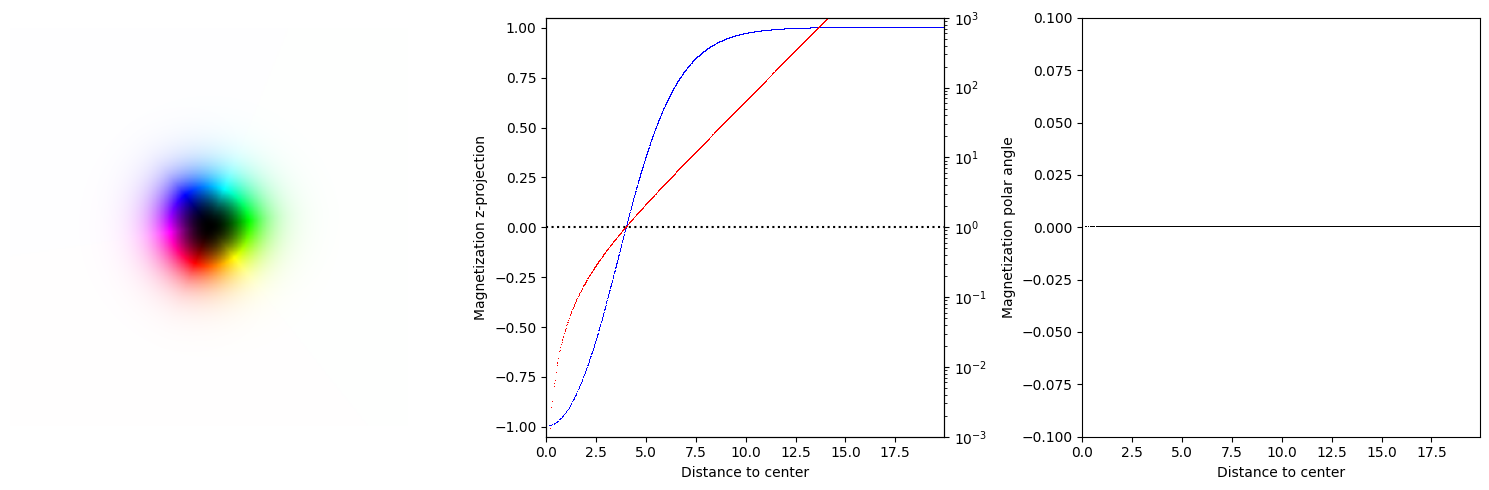

In [139]:
system = mg.System(
    Lx=40, Ly=40, Di=3.5, K=7.7, H=1, A=1,
    eta=0.2, jx=0, beta=0.,
)
print(system)

comp = mg.Computer2(system)
xy = comp.coordinates(300, 300)

a1 = mg.Thiele(ansatz, computer=comp, args=[xy])
a2 = Analytic(system=system, xy=xy)
a3 = mg.AnalyticA(system=system, xy=xy)
a4 = AnalyticI(system=system, xy=xy)

rad0 = 4.
wdt0 = 3.

p0 = np.array([system.Lx/2,system.Ly/2,rad0,wdt0,0,0,0.0])
print(f"Initial parameters {p0}")
n1 = a1(p0)
n2 = a2(p0)
n3 = a3(p0)
n4 = a4(p0)
print(f"Ansatzes distinction {np.max(np.abs(n1-n2))} {np.max(np.abs(n1-n3))} {np.max(np.abs(n1-n4))}")

mg.analyze_geometry(n1, xy);
# mg.analyze_geometry(n2, xy);

print("Energy micromagnetic", comp.energy(n1), comp.energy(n3))
print("Energy 1D", a2.energy(p0))
print("Energy analytic", a3.energy(p0))
print("Energy integral", a4.energy(p0))


# print(f"Gradient of energy")
# A,B,dE,jx,jy,jx2,jy2 = a1.equation(p0)
# print(f"Numeric  {np.round(dE,3)}")
# print(f"1D       {np.round(a2.d_energy(p0),3)}")
# A_2,B_2,dE_2,jx_2,jy_2,jx2_2,jy2_2 = a3.equation(p0)
# print(f"analytic {np.round(dE_2,3)}")

# print(f"Time derivative")
# print(f"Numeric  {a1.time_derivative(p0)}")
# print(f"Analytic {a3.time_derivative(p0)}")

def print_equation(a, p0, f=1e1):
    A,B,dE,jx,jy,jx2,jy2 = a.equation(p0)
    print(f"B=\n{(B*f).astype(int)}")
    print(f"A=\n{(A*f).astype(int)}")
    print(f"dE={(dE*f).astype(int)}")
    print(f"jx={(jx*f).astype(int)}")
    print(f"jy={(jy*f).astype(int)}")
    print(f"n x jx={(jx2*f).astype(int)}")
    print(f"n x jy={(jy2*f).astype(int)}")
    
# print("\nThiele")
# print_equation(a1, p0)
print("\nAnalytic")
print_equation(a3, p0)
print("\nIntegral")
print_equation(a4, p0)



# print("\nThiele")
# print(a1.time_derivative(p0))
# print("\nAnalytic")
# print(a3.time_derivative(p0))


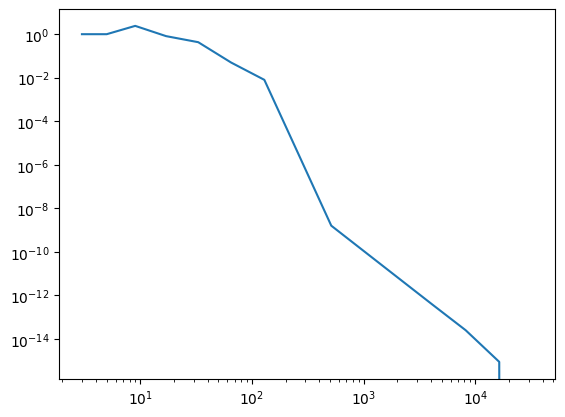

In [127]:
nints = 1+2**np.arange(1,16)
vals = np.empty(nints.shape, dtype=np.float64)
for n, nint in enumerate(nints):
    a4.nint = nint
    vals[n] = a4.energy(p0)
    
plt.loglog(nints, np.abs(1-vals/vals[-1]) )

In [87]:
krads = np.arange(1,20)
vals = np.empty(krads.shape, dtype=np.float64)
for n, krad in enumerate(krads):
    a4.krad = krad
    vals[n] = a4.energy(p0)
    
plt.semilogy(krads, np.abs(1-vals/vals[-1]) )

In [ ]:
print(jnp.round(A,3))
print(jnp.round(A_2,3))


In [ ]:
print(jnp.round(B,3))
print(jnp.round(B_2,3))

# Dynamics

In [16]:
def show(filename, name):
    data0, figax = mg.plot_result(f"{filename}.npz")
    data1, figax = mg.plot_result(f"{filename}_{name}.npz", figax=figax, suffix=name, label=f'Thiele', color='k')
    plt.savefig(f"{filename}.summary_{name}.pdf")
    plt.show()


def exp_expl_rwc(filename, name='expl_rwc'): # radius, width, chirality
    return mg.execute_experiment(filename, 
        ansatz=mg.AnalyticA(), 
        name=name,
        fit=mg.fit_params,
        dt=0.1,
        save_state=lambda p:[],
        encode=lambda p: p,
        decode=lambda e: e,             
    ), name

def exp_expl_rc(filename, name='expl_rc'): # radius, chirality
    return mg.execute_experiment(filename, 
        ansatz=mg.AnalyticB(), 
        name=name,
        fit=mg.fit_params,
        dt=0.1,
        save_state=lambda p:[],
        encode=lambda p: p,
        decode=lambda e: e,             
    ), name

def exp_expl_r(filename, name='expl_r'): # radius
    return mg.execute_experiment(filename, 
        ansatz=mg.AnalyticR(), 
        name=name,
        fit=mg.fit_params,
        dt=0.1,
        save_state=lambda p:[],
        encode=lambda p: p,
        decode=lambda e: e,             
    ), name




Output()

Saving to expl_r
Loaded system System(A=1, J=1, Db=0, Di=0.3, H=0.09, K=0, Lx=60, Ly=30, Ms=1, gamma=1, eta=0.2, beta=0.2, jx=0.01, jy=0.0, imp_x=array([30.]), imp_y=array([11.]), imp_K=array([-0.5]))
Data shape (3, 200, 100, 1)
Read parameters [4.72110363e+01 1.49991970e+01 3.24014336e+00 3.11211413e+00
 1.35699581e-06 5.08536462e-06 1.47284097e-06]
Computed parameters [4.72110363e+01 1.49991970e+01 3.24014336e+00 3.11211413e+00
 1.35699581e-06 5.08536462e-06 1.47284097e-06]
Encoded parameters [4.72110363e+01 1.49991970e+01 3.24014336e+00 3.11211413e+00
 1.35699581e-06 5.08536462e-06 1.47284097e-06]
Decoded parameters [4.72110363e+01 1.49991970e+01 3.24014336e+00 3.11211413e+00
 1.35699581e-06 5.08536462e-06 1.47284097e-06]
Re-encoded parameters [4.72110363e+01 1.49991970e+01 3.24014336e+00 3.11211413e+00
 1.35699581e-06 5.08536462e-06 1.47284097e-06]
Number of arguments 7


Initial LLF    [4.72110363e+01 1.49991970e+01 3.24014336e+00 3.11211413e+00
 1.35699581e-06 5.08536462e-06 1.47284097e-06]
Final LLF      [9.05600350e+00 1.63956194e+01 3.15320315e+00 3.15373589e+00
 8.83281314e-04 1.67136039e-03 4.79279422e-04]
Initial Thiele    [4.72110363e+01 1.49991970e+01 3.24014336e+00 3.11211413e+00
 1.35699581e-06 5.08536462e-06 1.47284097e-06]
Final Thiele      [4.97548966e+00 1.96246645e+01 6.99934036e+00 3.11211413e+00
 1.35699581e-06 5.08536462e-06 1.47284097e-06]


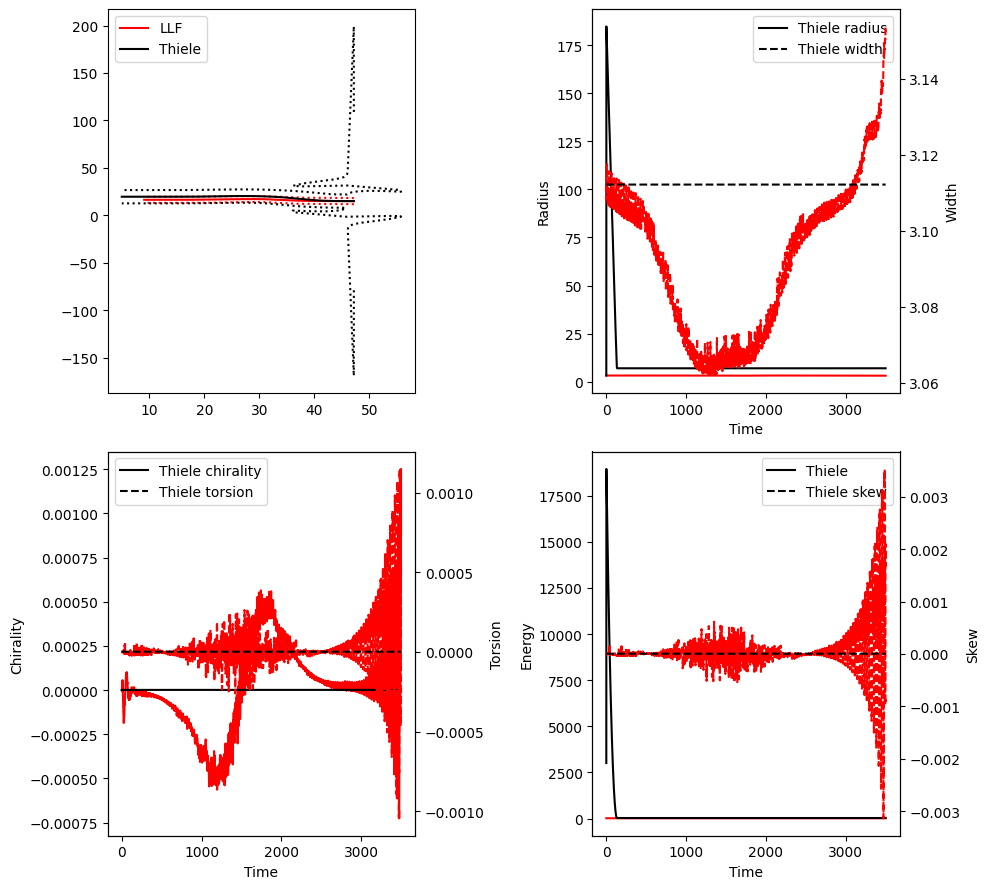

In [19]:
def run(filename):
    _, name = exp_expl_r(filename)
    show(filename, name)


# folder = '../tmp8/rlx_Lx18_D3.5_K7.7_H0_eta0.2_sx900/'
# folder = '../tmp9/rlx_Lx18_D3.5_K7.7_H0_eta0.2_sx300/'
# folder = '../tmp9/rlx_Lx18_D2.5_K4_H0.0_eta0.5_sx300/'
# folder = '../tmp10/rlx_Lx20_D2.5_K2_H0.5208333333333334_eta0.5_sx400/'
folder = '../tmp11/rlx_Lx60_D0.3_K0_H0.09_sx200/'


# run(f"{folder}/stbl")
# run(f"{folder}/aply")
# run(f"{folder}/relx")
# run(f"{folder}/aply_current")
# run(f"{folder}/stbl_current")
# run(f"{folder}/stbl_current_apply2")
run(f"{folder}/curimp2_j0.01_beta0.2_K-0.5_y11.0")


# run(f"{folder}/cur1")
# run(f"{folder}/cur1_eta0.1_beta0.1")
# run(f"{folder}/cur1_eta0.1_beta0.0")
# run(f"{folder}/cur1_j1.0_beta0.2")


In [8]:
# folder = '../tmp6/rlx_Lx18_D3.5_K7.7_H0_eta0.2_sx300/'
# folder = '../tmp6/rlx_Lx18_D3.5_K7.7_H0_eta0.2_sx300/'

# filename = f"{folder}/stbl"
# filename = f"{folder}/aply"
# filename = f"{folder}/relx"
# filename = f"{folder}/cur1"
# filename = f"{folder}/cur1_beta0.1"
# filename = f"{folder}/cur1_eta0.1_beta0.1"
# filename = f"{folder}/cur1_eta0.1_beta0.1"

# data = np.load(f"{filename}_rc.npz")
# hist=data['hist_rc']   
# print(hist)
# fig, ax = plt.subplots()
# plot_param_trajectory(hist, ax=ax)


# show(filename, 'expl')

# Experiment parameters search using analytics prediction

In [49]:
def plot_result(filename, figsize=(10,9), figax=None, suffix='llg', label='LLF', color='r'):
    data = np.load(f'{filename}', allow_pickle=True)
    time, hist, energy = (
        data['time'], data[f'hist_{suffix}'], data[f'energy_{suffix}'], 
    )

    if figax is None:
        fig, ax = plt.subplots(2, 2, figsize=figsize, squeeze=False)
        bx = ax[0][1].twinx()
        cx = ax[1][0].twinx()
        dx = ax[1][1].twinx()
    else:
        fig, ax, bx, cx, dx = figax
        
    mg.plot_param_trajectory(hist, ax=ax[0][0], color=color, label=label)
    ax[0][0].legend()

    aa = ax[0][1]
    ln1 = aa.plot(time, hist[:,2], '-', color=color, label=f'{label} radius')
    ln2 = bx.plot(time, hist[:,3], '--', color=color, label=f'{label} width')
    aa.set_ylim(0,None)
    bx.set_ylim(0,None)    
    aa.set_xlabel('Time')
    aa.set_ylabel('Radius')
    bx.set_ylabel('Width') 
    
    lns = ln1+ln2
    aa.legend(lns, [l.get_label() for l in lns])

    aa = ax[1][0]
    ln1 = aa.plot(time, hist[:,4], '-', color=color, label=f"{label} chirality")
    angle = np.arctan2(np.diff(hist[:,1],1), np.diff(hist[:,0],1))
    ln2 = cx.plot(time[:-1], angle, '--', color=color, label=f"{label} Hall angle")    
    aa.set_xlabel('Time')
    aa.set_ylabel('Chirality')
    cx.set_ylabel('Hall angle')

    lns = ln1+ln2
    aa.legend(lns, [l.get_label() for l in lns])
    
    aa = ax[1][1]
    ln1 = aa.plot(time, energy, '-', color=color, label=label)
#     ln2 = dx.plot(time, hist[:,5], '--', color=color, label=f"{label} skew")
    aa.set_xlabel('Time')
    aa.set_ylabel('Energy') 
#     dx.set_ylabel('Skew') 
    lns = ln1#+ln2
    aa.legend(lns, [l.get_label() for l in lns])

    plt.tight_layout()
    
    print(f"Initial {label}    {hist[0]}")
    print(f"Final {label}      {hist[-1]}")
    
    return data, (fig, ax, bx, cx, dx)

def run_analytics(system, p0, filename, period=1.0):
    _, hist, _ = mg.run_analytic_dynamics(
        p0, ansatz=mg.AnalyticA(system), 
        simulation_period=period, dt=0.001, report_time=0.02,
        filename = filename,
    )

    data0, figax = plot_result(f"{filename}_analytic.npz", suffix='analytic',label='Analytics')
    plt.savefig(f"{filename}.summary.pdf")
    plt.show()
    
    return hist[-1]
    

folder = '../tmp9/rlx_Lx18_D3.5_K7.7_H0_eta0.2_sx300/'

In [2]:
system = mg.System(
    Lx=18, Ly=18, D=1, K=1, H=0.,
    eta=0.2, jx=0, beta=0.,
)


rad0 = 2.14687
wdt0 = 0.78539
p0 = jnp.array([system.Lx-2*rad0,0*system.Ly+2*rad0,rad0,wdt0,-np.pi/2,0,0.0])

p1 = run_analytics(system, p0, filename=f"{folder}/probe", period=1.)


Spin spiral width 12.566370614359172


NameError: name 'run_analytics' is not defined

In [29]:
# H=-0.1 => unstable skyrmion => drastic change of Hall angle
# H=-0.09 = > no influence on Hall angle (2.83 -> 2.79 rad).
# H=1.5 => Skyrmons shrink from radius 2.14 to 0.6, but no Hall angle change.
system2 = replace(system, H=1.5, jx=0.3, eta=0.2)
print(system2)

p2 = run_analytics(system2, p1, filename=f"{folder}/probe_excite", period=40.)


Output()

System(A=1, J=1, D=1, H=1.5, K=1, Lx=18, Ly=18, Ms=1, gamma=1, eta=0.2, beta=0.0, jx=0.3, jy=0.0, imp_x=array([], dtype=float64), imp_y=array([], dtype=float64), imp_K=array([], dtype=float64))


Initial Analytics    [13.70626    -4.29374     2.1468686   0.78539675 -1.57079551  0.
  0.        ]
Final Analytics      [ 2.7522031  -0.91814555  0.61699204  0.25674915 -7.85398163  0.
  0.        ]


In [41]:
system3 = replace(system, K=0.65, jx=0.3, eta=0.1)
print(system3)

p3 = run_analytics(system3, p1, filename=f"{folder}/probe_ani", period=100.)


Output()

System(A=1, J=1, D=1, H=1.5, K=1, Lx=18, Ly=18, Ms=1, gamma=1, eta=0.2, beta=0.0, jx=0.3, jy=0.0, imp_x=array([], dtype=float64), imp_y=array([], dtype=float64), imp_K=array([], dtype=float64))


Initial Analytics    [13.70626    -4.29374     2.1468686   0.78539675 -1.57079551  0.
  0.        ]
Final Analytics      [-14.4183571    2.92184365   5.83559136   1.20925949  -1.5731966
   0.           0.        ]


Output()

System(A=1, J=1, D=1.2, H=0.0, K=1, Lx=18, Ly=18, Ms=1, gamma=1, eta=0.1, beta=0.0, jx=0.3, jy=0.0, imp_x=array([], dtype=float64), imp_y=array([], dtype=float64), imp_K=array([], dtype=float64))


Initial Analytics    [13.70626    -4.29374     2.1468686   0.78539675 -1.57079551  0.
  0.        ]
Final Analytics      [-15.17406064   1.37620597   3.39171499   0.94247733  -1.57078678
   0.           0.        ]


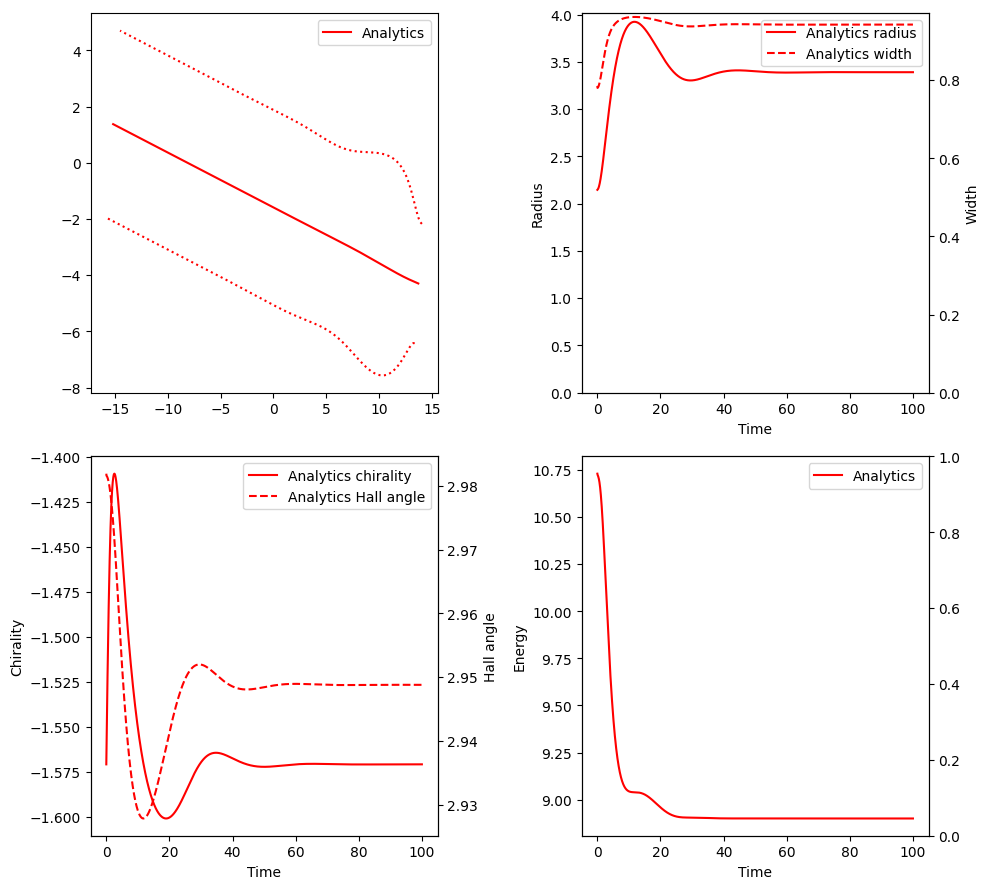

In [55]:
system4 = replace(system, D=1.2, jx=0.3, eta=0.1)
print(system4)

p4 = run_analytics(system4, p1, filename=f"{folder}/probe_dm", period=100.)
